# k Nearest Neighbours and cross-validation

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('house-prices-train.csv')
data.SalePrice = np.log1p(data.SalePrice)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

## data cleaning (copy/pasted from the previous tutorial)

In [3]:
from sklearn.preprocessing import LabelEncoder
def encode_categories(df, mappers, dummies=False):
    le = LabelEncoder()
    for col in df.select_dtypes('object').columns:
        if col not in mappers and df[col].nunique() < 30:
            df[col] = df[col].fillna('NaN')
            df[col] = le.fit_transform(df[col])
            if dummies:
                prefix = 'd_' + col
                df = pd.concat([df.drop(columns=[col]), pd.get_dummies(df[col], prefix=prefix)], axis=1)
        elif col in mappers:
            df[col] = df[col].replace(mappers[col])
    return df

In [4]:
data = pd.read_csv('house-prices-train.csv')
data.SalePrice = np.log1p(data.SalePrice)
ordinal_cols_mappers = {
    'KitchenQual': {'Po' : 0, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4}
}
data = encode_categories(data, ordinal_cols_mappers, True)
data.shape

(1460, 303)

  * The nature of kNN algorithms means that using kNN with nominal features is troublesome.
  * To overcome this, one can adopt one of these strategies:
    * Drop nominal features (and possibly keep the ordinal one if there is some meaning for measuring the distance).
    * Replace nominal features with dummies using one-hot encoding.
    * Use some [more sophisticated metrics](https://www.researchgate.net/publication/220907006_Similarity_Measures_for_Categorical_Data_A_Comparative_Evaluation) capable of measuring the similarity of nominal features.
  * We will give a try to the first two approaches.

## First attempt

In [10]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)

In [6]:
knn.fit(data.drop(columns=['SalePrice']), data.SalePrice)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  * There is a problem with missing values of numeric features.

In [7]:
data.loc[:,data.isnull().sum() > 0].isnull().sum()

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [8]:
data[data.GarageYrBlt.notnull()]['GarageYrBlt'].mean()

1978.5061638868744

In [31]:
from sklearn.model_selection import ParameterGrid, train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(data.drop(columns=['SalePrice']), 
                                                data.SalePrice, 
                                                test_size=0.25, 
                                                random_state=6548)
missing_cols = data.loc[:,data.isnull().sum() > 0].columns

In [25]:
# isnull vraci masku, muzeme ji potom pouzit znovu v [] na vyfiltrovani dat
Xtrain[Xtrain['LotFrontage'].isnull()]

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
817    818          20          NaN    13265            8            5   
203    204         120          NaN     4438            6            5   
244    245          60          NaN     8880            7            5   
882    883          60          NaN     9636            6            5   
393    394          30          NaN     7446            4            5   
...    ...         ...          ...      ...          ...          ...   
868    869          60          NaN    14762            5            6   
1407  1408          20          NaN     8780            5            5   
1348  1349          20          NaN    16196            7            5   
412    413          20          NaN     4403            7            5   
559    560         120          NaN     3196            7            5   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  d_SaleType_5  \
817        2002          2002       148.0        1218  ...             0   
203        2004          2004       205.0         662  ...             0   
244        1994          2002         0.0         695  ...             0   
882        1992          1993         0.0           0  ...             0   
393        1941          1950         0.0         266  ...             0   
...         ...           ...         ...         ...  ...           ...   
868        1948          1950         0.0           0  ...             0   
1407       1985          1985         0.0         625  ...             0   
1348       1998          1998         0.0        1443  ...             0   
412        2009          2009       432.0         578  ...             0   
559        2003          2004        18.0           0  ...             0   

      d_SaleType_6  d_SaleType_7  d_SaleType_8  d_SaleCondition_0  \
817              0             0             1                  0   
203              0             0             1                  0   
244              0             0             1                  0   
882              0             0             1                  0   
393              0             0             1                  1   
...            ...           ...           ...                ...   
868              0             0             1                  0   
1407             0             0             1                  0   
1348             0             0             1                  0   
412              1             0             0                  0   
559              0             0             1                  0   

      d_SaleCondition_1  d_SaleCondition_2  d_SaleCondition_3  \
817                   0                  0                  0   
203                   0                  0                  0   
244                   0                  0                  0   
882                   0                  0                  0   
393                   0                  0                  0   
...                 ...                ...                ...   
868                   0                  0                  0   
1407                  0                  0                  0   
1348                  0                  0                  0   
412                   0                  0                  0   
559                   0                  0                  0   

      d_SaleCondition_4  d_SaleCondition_5  
817                   1                  0  
203                   1                  0  
244                   1                  0  
882                   1                  0  
393                   0                  0  
...                 ...                ...  
868                   1                  0  
1407                  1                  0  
1348                  1                  0  
412                   0                  1  
559                   1                  0  

[190 rows x 302 columns]

In [32]:
for col in missing_cols:
    XMissing = Xtrain[Xtrain[col].isnull()].drop(columns = missing_cols)
    m_idx = Xtrain[Xtrain[col].isnull()].index
    XNotMissing = Xtrain[Xtrain[col].notnull()].drop(columns = missing_cols)
    YNotMissing = Xtrain[Xtrain[col].notnull()][col]
    kNN = KNeighborsRegressor(n_neighbors=5)
    kNN.fit(XNotMissing, YNotMissing)
    ym_pred = kNN . predict(XMissing)
    Xtrain . loc[m_idx, col] = ym_pred
    XTm 
display(Xtrain.describe())

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1095.000000  1095.000000  1095.000000    1095.000000  1095.000000   
mean    738.314155    56.680365    70.969315   10494.927854     6.083105   
std     421.530722    42.219698    23.118261    9348.534891     1.404953   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     375.500000    20.000000    60.000000    7549.000000     5.000000   
50%     736.000000    50.000000    70.000000    9503.000000     6.000000   
75%    1099.500000    70.000000    81.200000   11466.000000     7.000000   
max    1460.000000   190.000000   313.000000  164660.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1095.000000  1095.000000   1095.000000  1095.000000  1095.000000  ...   
mean      5.562557  1972.102283   1985.108676   105.256438   455.597260  ...   
std       1.118837    29.808937     20.525235   182.422592   458.016201  ...   
min       1.000000  1880.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.500000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   403.000000  ...   
75%       6.000000  2001.000000   2004.000000   169.000000   733.000000  ...   
max       9.000000  2009.000000   2010.000000  1600.000000  5644.000000  ...   

       d_SaleType_5  d_SaleType_6  d_SaleType_7  d_SaleType_8  \
count   1095.000000   1095.000000   1095.000000   1095.000000   
mean       0.002740      0.084018      0.002740      0.869406   
std        0.052295      0.277542      0.052295      0.337109   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      1.000000   
50%        0.000000      0.000000      0.000000      1.000000   
75%        0.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000   

       d_SaleCondition_0  d_SaleCondition_1  d_SaleCondition_2  \
count        1095.000000        1095.000000        1095.000000   
mean            0.067580           0.002740           0.008219   
std             0.251138           0.052295           0.090328   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             0.000000           0.000000           0.000000   
max             1.000000           1.000000           1.000000   

       d_SaleCondition_3  d_SaleCondition_4  d_SaleCondition_5  
count        1095.000000        1095.000000        1095.000000  
mean            0.014612           0.821005           0.085845  
std             0.120048           0.383524           0.280263  
min             0.000000           0.000000           0.000000  
25%             0.000000           1.000000           0.000000  
50%             0.000000           1.000000           0.000000  
75%             0.000000           1.000000           0.000000  
max             1.000000           1.000000           1.000000  

[8 rows x 302 columns]

What we can do:
  * Drop the data points with missing values. But we do not have enough data for this.
  * We can replace the missings with respective means. But it is too simple, and we have some dignity!
  * We can predict the missing values from the rest of the data! That's it! We will use the kNN algorithm.

### Task: predict the missing values using kNN

The idea is this (assume we want to fill missing values in `LotFrontage` column):
  * Split the dataset into two parts: 
    * `D1` = contaning the lines with missing values in `LotFrontage` column, 
    * `D2` = the rest of the data.
  * Save the column `D2.LotFrontage` to `Y` and the remaining columns to `X` (exclude some columns if needed). The same columns of `D1` save to `X2`.
  * Fit a model (we use the kNN) to predict `Y` using `X`.
  * Use this model to predict the missing values of `LotFrontage` using the `X2` data.

In [ ]:
def replace_nans(df, cols_nan, params):
    ### your code goes here
    
    ###
    return df

Let us check that we have some meaningful results:

In [ ]:
df = data.copy()
cols_nan = df.loc[:,data.isnull().sum() > 0].columns
params = {
        'n_neighbors': 5
}
df = replace_nans(df, cols_nan, params)
display(data[cols_nan].describe())
display(dataNoNan[cols_nan].describe())

## Cross-validation and hyperparameter tuning

  * Assume we want to go through the following values of the kNN hyperparameters.
  * Beside this, we also want to see the effect of different strategies of 
    * how to deal with nominal features (ignoring them, using dummies), 
    * how to normalise the data (no normalising vs normalising).

In [ ]:
data = df.copy()
data = data.drop(columns=['Id'])

### Task: implement cross validation

In [ ]:
def cross_val(X, y, folds, model, dummies = False):
    averageRMSLE = 0
    np.random.seed(seed=654) # this must be here, explain WHY!
    ### Your code goes here
    
    ###
    return averageRMSLE

### Task: try kNN with and without normalisation/dummies

In [ ]:
from sklearn.model_selection import ParameterGrid, train_test_split
param_grid = {
    'n_neighbors' : range(1,20),
    'p': range(1,5),
    'weights': ['uniform', 'distance']
}
dummies = True
param_comb = ParameterGrid(param_grid)
Xtrain, Xtest, ytrain, ytest = train_test_split(data.drop(columns=['SalePrice']), 
                                                data.SalePrice, 
                                                test_size=0.25, 
                                                random_state=6548)
### your code doing normalisation goes here:

###
crossval_err = []
for params in param_comb:
    kNN = KNeighborsRegressor(**params)
    averageRMSLE = cross_val(Xtrain.copy(), ytrain, 12, kNN, dummies)
    crossval_err.append(averageRMSLE)
crossval_err

In [ ]:
%%time
best_params = param_comb[np.argmin(crossval_err)]
kNN = KNeighborsRegressor(**best_params)
if not dummies:
    Xtrain = Xtrain.loc[:, Xtrain.nunique() > 3]
    Xtest = Xtest.loc[:, Xtrain.columns]
Xtest.fillna(0, inplace=True)
print(Xtrain.shape, Xtest.shape)

kNN.fit(Xtrain, ytrain)
ypred = kNN.predict(Xtest)
best_RMSLE = math.sqrt(metrics.mean_squared_error(ytest, ypred))
print('RMSLE (test): {0:.6f}'.format(best_RMSLE))
print('best parameters:', best_params)

There are of course packages in `sklearn` for Cross-Validation and normalisation:
  * [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
  * [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
  * [cross_validate](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
  * [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

### Curse of dimensionality

  * Normalised data are all localised in the $n$-dimensional cube with sides of length one.
  * The diagonal of this cube equals $\sqrt{n}$.
  * The curse of dimensionality says that higher the dimension the nearest neighbours get further and further.
  * To measure this effect, we will increase the dimension and observe the ration of the diagonal and the mean distance of the nearest neighbours.

**Try to experiment with the `n_neighbors` parameter!** What is the influence of the number of neigbours and the mean distance?

In [44]:
# Xtrain and Xtest should be normalized here
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain = pd.DataFrame( scaler . fit_transform(Xtrain) )
mean_dist_ratio = []
for k in range(1,30):
    kNN = KNeighborsRegressor(n_neighbors=150, p=2)
    kNN.fit(Xtrain.iloc[:,0:k], ytrain)
    dist, nn = kNN.kneighbors(Xtest.iloc[:,0:k])
    mean_dist_ratio.append(np.mean(dist)/math.sqrt(k))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

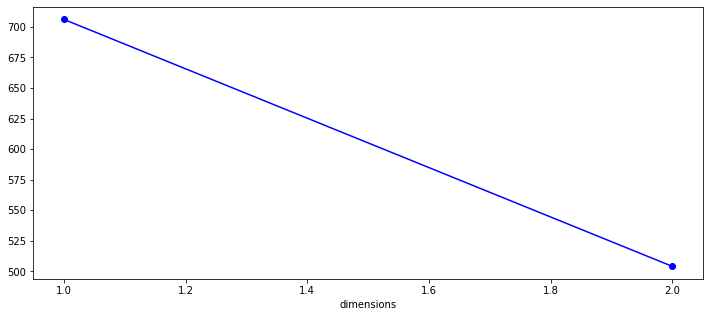

In [45]:
plt.figure(figsize=(12,5))
plt.xlabel('dimensions')
plt.plot(range(1,len(mean_dist_ratio)+1),mean_dist_ratio,'bo-')